# Project: Effects of volcanic forcing on global mean temperature based on the historical Tambora eruption

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from scipy.stats import norm, skewnorm
from numpy import random
from mpl_toolkits.mplot3d.axes3d import Axes3D

## 0-D EBM

The 0-Degree Energy Balance Model is given below:

$$
c_e \frac{dT_s}{dt} = \frac{S_0(t)[1-\alpha]}{4} - \epsilon \sigma T_s^4
$$

The effects of volcanic forcing are modeled through changes in $S_0$ with respect to time.

In [2]:
def ebm(time, solar, t_init, ce, alpha, eps, sigma):
    """
    Run the 0-D EBM model with given parameters. The time is precomputed, and
    the solar is passed as an array.

    Args:
        time (np.ndarray): The array of time values to simulate.
        solar (np.ndarray): The array of solar constant values over time. Has
            the same length as the time array.
        t_init (float): Absolute temperature of the surface at timestep 0 in K.
        ce (float): Heat capacity in J / (K * m^2).
        alpha (float): Planetary albedo, no unit.
        eps (float): Effective emissivity, no unit.
        sigma (float): Stefan-Boltzmann constant in W / (m^2 * K^4)
    
    Returns:
        np.ndarray of absolute surface temperature, same length as time array
    """

    # absolute surface temperature
    t_s = np.zeros_like(time,dtype=np.float64)
    t_s[0] = t_init

    for it in range(1, len(time)):

        shortwave = np.float64(0.25 * solar[it] * (1.0 - alpha))
        longwave = np.float64(eps * sigma * (t_s[it-1]**4))

        dt = np.float64(time[it]) - np.float64(time[it-1])

        t_s[it] = np.float64(t_s[it-1] + dt * (shortwave - longwave) / ce)

    return t_s

In [3]:
def generate_time(dt, n_iters):
    """
    Generate the time array. Example: generate_time(24*3600, 365) would generate
    one year worth of timesteps.

    Args:
        dt (float): The time delta in seconds
        n_iters (int): How many timesteps dt time apart to generate
    """

    time = np.arange(n_iters, dtype=np.float64) * dt

    return time

## Modelling solar constant change

The effect of volcanic activity is modelled by adding a Gaussian-shaped dip in the solar constant. The function below allows to generate such a solar constant profile.

### **THIS PART IS JUST FOR TESTING, ADD CODE LATER**.

In [4]:
def gaussian(x, mu, sig):
    return np.exp(-(x - mu)**2 / (2 * sig**2))

In [5]:
def generate_solar_skewed(time, val, dip_timestep, dip_height, dip_width,skewdness):
#step, dip_height, dip_width,skewdness)
    """
    Generate solar profile with dip.

    Args:
        time (np.ndarray): Time steps.
        val (float): Value of solar without dip.
        dip_timestep (int): Timestep when dip occurs.
        dip_height (float): Height of the dip.
        dip_width (float): Width of the dip.
        About 68% of values drawn from a normal distribution are within one standard deviation σ away from the mean; 
        about 95% of the values lie within two standard deviations;
        and about 99.7% are within three standard deviations 'Normal Distribution'. www.mathsisfun.com. Retrieved August 15, 2020.
        skewdness (float): The distribution is right skewed if α > 0  and is left skewed if α < 0 
    Returns: 
        Solar numpy array with dip.
    """

    timesteps = np.arange(len(time))
    solar = np.ones_like(time,dtype=np.float64) * val

    #gauss = gaussian(timesteps, dip_timestep, dip_width)
    #gauss = gauss / gauss.max() * dip_height
    #gauss = norm.pdf(timesteps,loc=dip_timestep,scale=dip_width)
    #gauss = gauss / gauss.max() * dip_height
    #skewdf = norm.cdf(skewdness*timesteps)
    #skewdf = skewdf/skewdf.max() #* dip_height
    skewdf2 = np.float64(skewnorm.pdf(timesteps,skewdness,loc=dip_timestep,scale=dip_width))
    skewdf2 = skewdf2/skewdf2.max()*np.float64(dip_height)
    #return solar - 2*gauss*skewdf
    return solar - skewdf2

In [6]:
def generate_solar_multiple_eruptions(time, val, dip_timestep, dip_height, dip_width,skewdness):
#step, dip_height, dip_width,skewdness)
    """
    Generate solar profile with multiple dips.
    Args:
        time (np.ndarray): Time steps.
        val (float): Value of solar without dip.
        dip_timestep (int): Timestep when dip occurs.
        dip_height (float): Height of the dip.
        dip_width (float): Width of the dip.
        About 68% of values drawn from a normal distribution are within one standard deviation σ away from the mean; 
        about 95% of the values lie within two standard deviations;
        and about 99.7% are within three standard deviations 'Normal Distribution'. www.mathsisfun.com. Retrieved August 15, 2020.
        skewdness (float): The distribution is right skewed if α > 0  and is left skewed if α < 0 
    Returns: 
        Solar numpy array with dip.
    """
    timesteps = np.arange(len(time))
    skewdf2 = {}
    #np.zeros(len(time),dtype=np.float64)
    solar = np.ones_like(time,dtype=np.float64) * val
    #gauss = gaussian(timesteps, dip_timestep, dip_width)
    #gauss = gauss / gauss.max() * dip_height
    #gauss = norm.pdf(timesteps,loc=dip_timestep,scale=dip_width)
    #gauss = gauss / gauss.max() * dip_height
    #skewdf = norm.cdf(skewdness*timesteps)
    #skewdf = skewdf/skewdf.max() #* dip_height
    #for height, timestep in zip(dip_height, dip_timestep):
    for i in range(len(dip_height)):
      skewdf2[i] = np.float64(skewnorm.pdf(timesteps,skewdness,loc=dip_timestep[i],scale=dip_width))
      skewdf2[i] = skewdf2[i]/skewdf2[i].max()*np.float64(dip_height[i])
      #solar -= sum(list(skewdf2.values()))
      #print(solar)
    #return solar - 2*gauss*skewdf
      
    return solar - sum(list(skewdf2.values()))

In [7]:
def equi_time(timestep_range, variable,epsilon):
    """ 
    Finds the time it takes for a variable to come back to equilibrium after an initial perturbation
    -------------
    ----input----
    -------------
    timestep_range: range of timesteps including an initial perturbation free case, 
                  then a perturbation and finally coming back to equilibrium

    variable: variable experiencing the perturbation
    epsilon: 
    """ 
    grad_v = np.gradient(np.float64(variable))#[timestep_range[0].index:timestep_range[-1]])
    try:
        for i in range(len(grad_v)):
            if grad_v[i] < 0:
                if abs(grad_v[i])>np.float64(epsilon):
                    start_timestep = i
                    break
        for i in range(len(grad_v)):      
            if grad_v[i] > 0 and i > np.float64(start_timestep):
                if abs(grad_v[i])< np.float64(epsilon):
                    equi_timestep = i
                    break

        return [start_timestep,equi_timestep,(timestep_range[equi_timestep] - timestep_range[start_timestep])/(3600*24*365)]
    except:
        return "Error"

# NRJ flux calculation
def nrj_flux(solar_signal,time_array):
    """Returns the absolute value of the total energy decrease in solar constant by trapezoidal integration in J"""
    return abs(np.float64(sp.integrate.trapz(solar_signal-1370,time_array))*total_surface_area_earth)





## Running and plotting the simulation

In [8]:
# constants
H = 70.0
rho = 1025.0
cp = 4000.0
ce = cp * H * rho

t_init = 285.15

alpha = 0.3

eps = 0.61

sigma = 5.67e-8


# generate time for N years
years = 50
time = generate_time(3600 * 24, years * 365)

# generate solar (constant for now)
solar_skewd_Tambora = generate_solar_skewed(time, 1370.0, 15 * 365, 7.5, 365*2,5)

In [9]:
VEI = np.arange(0,9,1)
tephra_volume = [10**4, 10**5,0.5*10**7,0.5*10**8,0.5*10**9,0.5*10**10,0.5*10**11,0.5*10**12,0.5*10**13]

density_tephra = 10**3 #kg/m^3
total_surface_area_earth = 4*np.pi*(6371*1000)**2
#total_surface_area_earth = 510072000*10**6 #m^2
VEI_scale= pd.DataFrame({"VEI":VEI,"ejected volume (m^3)": tephra_volume})
VEI_scale["ejected mass (g)"] = VEI_scale["ejected volume (m^3)"]*density_tephra/1000
VEI_scale["Thermal flux (cal/s)"] = 10**4*VEI_scale["ejected mass (g)"]
VEI_scale["Thermal flux (J/s)"] = VEI_scale["Thermal flux (cal/s)"]/4184
VEI_scale["Thermal flux (W/m^2)"] = VEI_scale["Thermal flux (J/s)"]/total_surface_area_earth
VEI_scale

,VEI,ejected volume (m^3),ejected mass (g),Thermal flux (cal/s),Thermal flux (J/s),Thermal flux (W/m^2)
0,0,1.000000e+04,1.000000e+04,1.000000e+08,2.390057e+04,4.685795e-11
1,1,1.000000e+05,1.000000e+05,1.000000e+09,2.390057e+05,4.685795e-10
2,2,5.000000e+06,5.000000e+06,5.000000e+10,1.195029e+07,2.342897e-08
3,3,5.000000e+07,5.000000e+07,5.000000e+11,1.195029e+08,2.342897e-07
4,4,5.000000e+08,5.000000e+08,5.000000e+12,1.195029e+09,2.342897e-06
5,5,5.000000e+09,5.000000e+09,5.000000e+13,1.195029e+10,2.342897e-05
6,6,5.000000e+10,5.000000e+10,5.000000e+14,1.195029e+11,2.342897e-04
7,7,5.000000e+11,5.000000e+11,5.000000e+15,1.195029e+12,2.342897e-03
8,8,5.000000e+12,5.000000e+12,5.000000e+16,1.195029e+13,2.342897e-02


In [10]:
print(total_surface_area_earth)

510064471909788.25


### Plot the solar constant over time

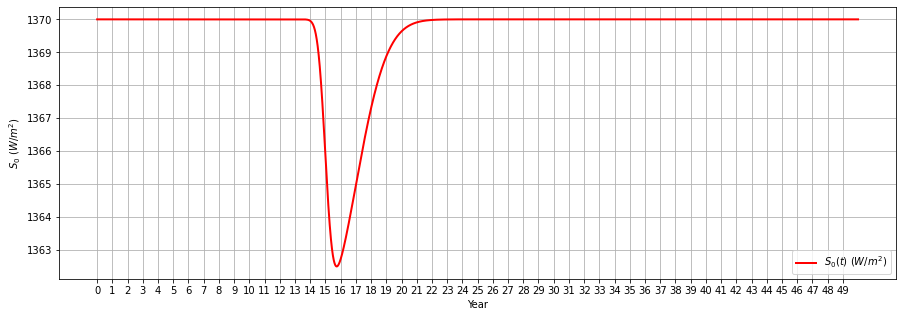

In [11]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# convert time axis to years 
time_years = time / (3600 * 24 * 365)

# plot temperature versus time
#ax.plot(time_years, solar, linewidth=2.0, color='blue')
ax.plot(time_years, solar_skewd_Tambora, linewidth=2.0, color='red', label="$S_0(t)~(W/m^2)$")

ax.set_xticks(time_years[::365])
ax.set_xticklabels(map(int, time_years[::365]))
ax.set_xlabel("Year")
ax.set_ylabel(r"$S_0$ ($W/m^2$)")
ax.grid()
ax.legend(loc="lower right")
plt.show()

In [12]:
print(f"total energy decrease in solar constant by trapezoidal integration = {format(nrj_flux(solar_skewd_Tambora,time),'.1E')} W/m^2")

total energy decrease in solar constant by trapezoidal integration = 3.3E+23 W/m^2


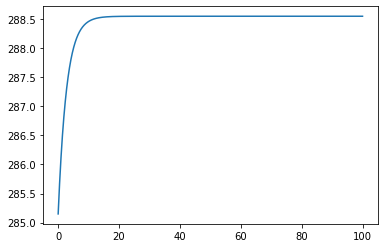

In [13]:
# run the simulation to equilibrium to get initial temperature
time_equi_run = generate_time(24*3600,365*100)
solar_equi_run = 1370*np.ones_like(time_equi_run)
t_s_equi_run = ebm(time_equi_run,solar_equi_run, t_init,ce, alpha,eps,sigma)
plt.plot(time_equi_run/(365*24*3600),t_s_equi_run)
plt.show()


In [14]:
equilibrium_threshold = 10**(-7)
for i in range(len(t_s_equi_run)):
  #print(np.gradient(t_s_equi_run)[i])
  if abs(np.gradient(t_s_equi_run)[i])< equilibrium_threshold and i > 10:
    equi_timestep = i
    break

t_s_equi = t_s_equi_run[equi_timestep]
print(f"The equilibrium temperature is {t_s_equi} K")

plot = False
if plot == True:
    plt.plot(np.gradient(t_s_equi_run))
    plt.axvline(equi_timestep)

The equilibrium temperature is 288.54348992845337 K


## Tambora eruption - close look

In [15]:
# run the simulations
time_run1 = generate_time(24*3600,365*50)
solar_skewd_run1 = generate_solar_skewed(time_run1, 1370.0, 15 * 365, 7.5, 365*2,5)
t_s_run1 = ebm(time_run1, solar_skewd_run1, t_s_equi, ce, alpha, eps, sigma)

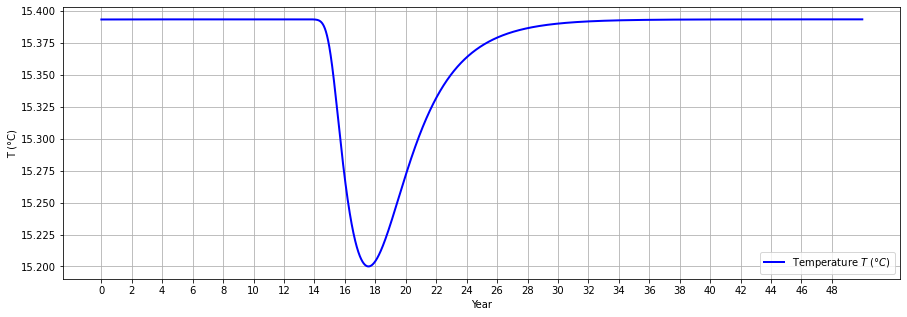

In [16]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# convert t_s to Celsius    
t_s_celsius_run1 = t_s_run1 - 273.15

# convert time axis to years 
time_years = time_run1 / (3600 * 24 * 365)

# plot temperature versus time
ax.plot(time_years, t_s_celsius_run1, linewidth=2.0, color='blue', label="Temperature $T~(°C)$")

ax.set_xticks(time_years[::365*2])
ax.set_xticklabels(map(int, time_years[::365*2]))#,rotation=-50)
ax.set_xlabel("Year")
ax.set_ylabel("T (°C)")
ax.legend(loc = "lower right")
plt.grid()
plt.show()

In [17]:
t_s_equi - min(t_s_run1)

0.19350089943350213

## timeseries of major volcanic eruptions (1850-2000)

In [18]:
eruption_time_array = [12,33,46,52,57.5,62.4,82,113.4,124.8,132.2,141.4]
eruption_time_array = [e*365 for e in eruption_time_array]
print(eruption_time_array)
eruption_height_array = [0.37,3.78,0.64,1.89,0.34,0.92,0.24,2.04,0.92,2.21,3.44]

[4380, 12045, 16790, 18980, 20987.5, 22776.0, 29930, 41391.0, 45552.0, 48252.99999999999, 51611.0]


In [19]:
# run the simulations
time_run_150 = generate_time(24*3600,365*150)
solar_skewd_run_150 = generate_solar_multiple_eruptions(time_run_150, 1370.0, eruption_time_array, eruption_height_array, 365,5)
t_s_run_150 = ebm(time_run_150, solar_skewd_run_150, t_s_equi, ce, alpha, eps, sigma)

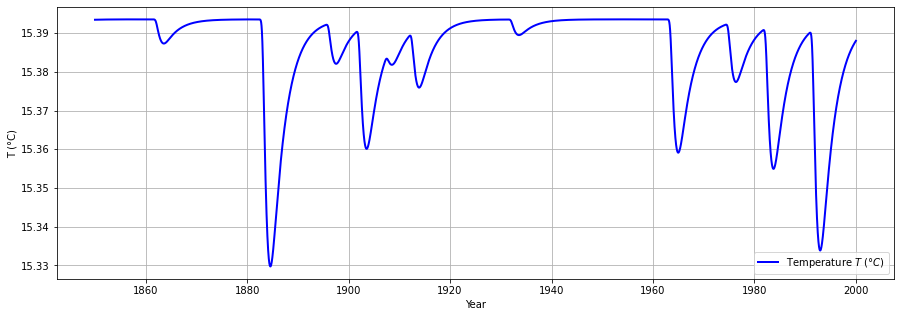

In [20]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# convert t_s to Celsius    
t_s_celsius_run_150 = t_s_run_150 - 273.15

# convert time axis to years 
time_years_150 = time_run_150 / (3600 * 24 * 365) + 1850

# plot temperature versus time
ax.plot(time_years_150, t_s_celsius_run_150, linewidth=2.0, color='blue', label="Temperature $T~(°C)$")

#ax.set_xticks(time_years[::365*2])
#ax.set_xticklabels(map(int, time_years[::365*2]))#,rotation=-50)
ax.set_xlabel("Year")
ax.set_ylabel("T (°C)")
ax.legend(loc = "lower right")
#plt.text(0.5, 0.5, '6 inches x 2 inches')
plt.grid()
plt.show()

## Different eruptions types  

In [21]:
np.arange(0,2.5,0.05,dtype=np.float64) + np.arange(2.5,15,0.25,dtype=np.float64) 

array([ 2.5,  2.8,  3.1,  3.4,  3.7,  4. ,  4.3,  4.6,  4.9,  5.2,  5.5,
        5.8,  6.1,  6.4,  6.7,  7. ,  7.3,  7.6,  7.9,  8.2,  8.5,  8.8,
        9.1,  9.4,  9.7, 10. , 10.3, 10.6, 10.9, 11.2, 11.5, 11.8, 12.1,
       12.4, 12.7, 13. , 13.3, 13.6, 13.9, 14.2, 14.5, 14.8, 15.1, 15.4,
       15.7, 16. , 16.3, 16.6, 16.9, 17.2])

In [23]:
val = 1370.0

time_run = np.float64(generate_time(24*3600,20*365))
time_years = np.float64(time_run / (3600 * 24 * 365))
dip_timestep = 1

solar_skewd_run = {}
t_s_run = {}
run_param = {}
height_range = np.append(np.arange(0,2.5,0.05,dtype=np.float64),np.arange(2.5,15,0.5,dtype=np.float64) )
width_range = np.arange(0,3.5,0.25,dtype=np.float64)

nrj_sun_array = np.zeros((len(height_range),len(width_range)))#np.zeros((len(width_range),len(height_range)))#
equi_time_dic_array = np.zeros((len(height_range),len(width_range)))#np.zeros((len(width_range),len(height_range)))#
temp_ampli = np.zeros((len(height_range),len(width_range)))#np.zeros((len(width_range),len(height_range)))#

run_count = 0
for dip_height,h in zip(height_range,range(len(height_range))):
  #equi_time_dic[dip_height] = np.zeros(len(range(0, 20, 1)))
    for dip_width,w in zip(width_range,range(len(width_range))):
        skewdness = 5
        run_param[run_count] = [dip_height,dip_width]
        solar_skewd_run[run_count]=np.float64(generate_solar_skewed(time_run, val, dip_timestep, dip_height, dip_width*365, skewdness))
        t_s_run[run_count] = np.float64(ebm(time_run, solar_skewd_run[run_count], t_s_equi, ce, alpha, eps, sigma))
        
        if dip_height > 0 and dip_width >0:
            equi_time_dic_array[h][w] = equi_time(time_run, t_s_run[run_count],10**(-6))[-1]
            temp_ampli[h][w] = abs(t_s_equi - min(t_s_run[run_count]))
            nrj_sun_array[h][w] = nrj_flux(solar_skewd_run[run_count],time_run)


        run_count +=1



In [24]:
W,H = np.meshgrid(width_range,height_range)#,dtype=np.float64)

/var/folders/vj/2fsd02sj7rn0y103cxtdzbq80000gn/T/ipykernel_2286/2715819666.py:36: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(sun_nrj_plot,ax=ax1, cax = cbaxes,extend="both")


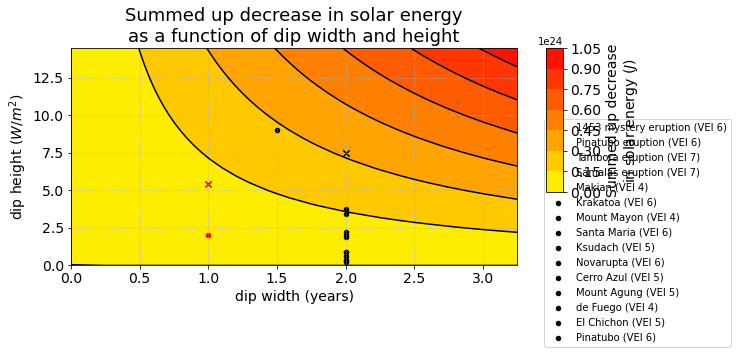

In [25]:
fig, ax1 = plt.subplots(figsize=(8,4))

sun_nrj_plot = ax1.contourf(W,H,nrj_sun_array,cmap="autumn_r")#,vmin=0,vmax=30)
#sun_nrj_plot = ax1.contourf(nrj_sun_array/(3600*24*365),cmap="autumn_r")#,vmin=0,vmax=30)

sun_nrj_contour = ax1.contour(W,H,nrj_sun_array,colors="k")#,vmin=0,vmax=20)
#sun_nrj_contour = ax1.contour(nrj_sun_array,colors="k")#,vmin=0,vmax=20)

#ax1.clabel(equi_time_contour, equi_time_contour.levels[:], inline=True, fontsize=10)

ax1.scatter(1,5.4,s=40,c="red",marker="x",label="1453 mystery eruption (VEI 6)")
ax1.scatter(1,2,s=20,c="red",label="Pinatubo eruption (VEI 6)")
ax1.scatter(2,7.5,s=40,c="k",marker="x",label="Tambora eruption (VEI 7)")
ax1.scatter(1.5,9,s=20,c="k",label="Samalas eruption (VEI 7)")

ax1.scatter(2, 0.37,s=20,c="k",label="Makian (VEI 4)")
ax1.scatter(2, 3.78,s=20,c="k",label="Krakatoa (VEI 6)")
ax1.scatter(2, 0.64,s=20,c="k",label="Mount Mayon (VEI 4)")
ax1.scatter(2, 1.89,s=20,c="k",label="Santa Maria (VEI 6)")
ax1.scatter(2, 0.34,s=20,c="k",label="Ksudach (VEI 5)")
ax1.scatter(2, 0.92,s=20,c="k",label="Novarupta (VEI 6)")
ax1.scatter(2, 0.24,s=20,c="k",label="Cerro Azul (VEI 5)")
ax1.scatter(2, 2.04,s=20,c="k",label="Mount Agung (VEI 5)")
ax1.scatter(2, 0.92,s=20,c="k",label="de Fuego (VEI 4)")
ax1.scatter(2, 2.21,s=20,c="k",label="El Chichon (VEI 5)")
ax1.scatter(2, 3.44,s=20,c="k",label="Pinatubo (VEI 6)")


ax1.tick_params(axis="both",labelsize=14)
ax1.set_xlabel("dip width (years)",fontsize=14)
ax1.set_ylabel("dip height $(W/m^2)$",fontsize=14)
ax1.set_title(f"Summed up decrease in solar energy\nas a function of dip width and height",fontsize=18)

# adding the colorbar
cbaxes = fig.add_axes([0.95, 0.38, 0.03, 0.5])
cb = fig.colorbar(sun_nrj_plot,ax=ax1, cax = cbaxes,extend="both")
cb.ax.tick_params(labelsize=14)
cb.set_label(label="Summed up decrease\nin solar energy ($J$)",fontsize=14)
ax1.grid(linestyle=":")
ax1.legend(loc="center right",bbox_to_anchor=(1.49,0.15))
plt.show()

/var/folders/vj/2fsd02sj7rn0y103cxtdzbq80000gn/T/ipykernel_2286/2171965014.py:19: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(equi_time_plot,ax=ax1, cax = cbaxes,extend="both")


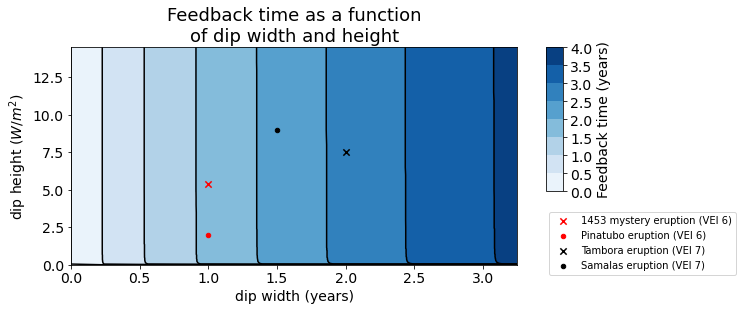

In [26]:
fig, ax1 = plt.subplots(figsize=(8,4))

equi_time_plot = ax1.contourf(W,H,equi_time_dic_array,cmap="Blues")#,vmin=0,vmax=30)

equi_time_contour = ax1.contour(W,H,equi_time_dic_array,colors="k")#,vmin=0,vmax=20)

#ax1.clabel(equi_time_contour, equi_time_contour.levels[:], inline=True, fontsize=10)
ax1.scatter(1,5.4,s=40,c="red",marker="x",label="1453 mystery eruption (VEI 6)")
ax1.scatter(1,2,s=20,c="red",label="Pinatubo eruption (VEI 6)")
ax1.scatter(2,7.5,s=40,c="k",marker="x",label="Tambora eruption (VEI 7)")
ax1.scatter(1.5,9,s=20,c="k",label="Samalas eruption (VEI 7)")
ax1.tick_params(axis="both",labelsize=14)
ax1.set_xlabel("dip width (years)",fontsize=14)
ax1.set_ylabel("dip height $(W/m^2)$",fontsize=14)
ax1.set_title(f"Feedback time as a function\nof dip width and height",fontsize=18)

# adding the colorbar
cbaxes = fig.add_axes([0.95, 0.38, 0.03, 0.5])
cb = fig.colorbar(equi_time_plot,ax=ax1, cax = cbaxes,extend="both")
cb.ax.tick_params(labelsize=14)
cb.set_label(label="Feedback time (years)",fontsize=14)



ax1.legend(loc="center right",bbox_to_anchor=(1.5,0.1))
plt.show()

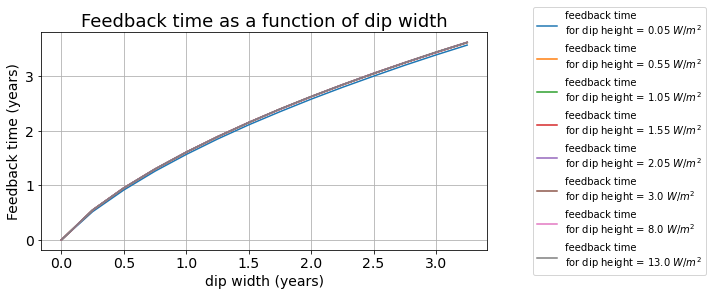

In [27]:
fig, ax1 = plt.subplots(figsize=(8,4))
for i in np.arange(1,len(height_range)+1,10):
    ax1.plot(width_range,equi_time_dic_array[i][:],label=f"feedback time\nfor dip height = {round(height_range[i],2)} $W/m^2$")#,cmap="Blues")#,vmin=0,vmax=30)
#h_range1 = list(np.arange(0,2.5,0.05))
#h_range2 = list(np.arange(2.5,15,0.5))
#for i in h_range1:
#    ax1.plot(width_range[i],equi_time_dic_array[i][:],label=f"feedback time\nfor dip height = {height_range[i]} $W/m^2$")#,cmap="Blues")#,vmin=0,vmax=30)         
#for i in h_range2:
#    ax1.plot(width_range[i],equi_time_dic_array[i][:],label=f"feedback time\nfor dip height = {height_range[i]} $W/m^2$")#,cmap="Blues")#,vmin=0,vmax=30)


ax1.tick_params(axis="both",labelsize=14)
ax1.set_xlabel("dip width (years)",fontsize=14)
ax1.set_ylabel("Feedback time (years)",fontsize=14)
ax1.set_title(f"Feedback time as a function of dip width",fontsize=18)

# adding the colorbar
ax1.grid()
ax1.legend(loc="center right",bbox_to_anchor=(1.5,0.5))
plt.show()

/var/folders/vj/2fsd02sj7rn0y103cxtdzbq80000gn/T/ipykernel_2286/4038214089.py:20: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = fig.colorbar(equi_time_plot,ax=ax1, cax = cbaxes,extend="both")


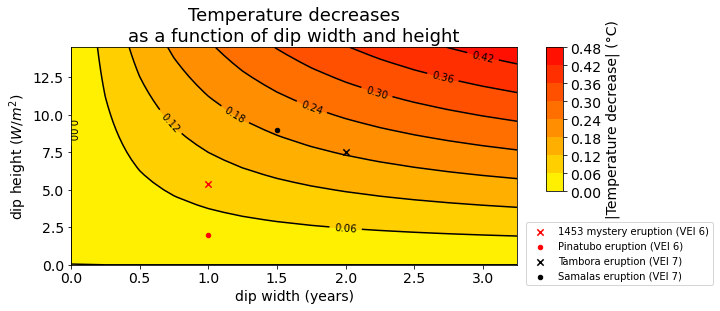

In [28]:
fig, ax1 = plt.subplots(figsize=(8,4))

equi_time_plot = ax1.contourf(W,H,temp_ampli,cmap="autumn_r")

equi_time_contour = ax1.contour(W,H,temp_ampli,colors="k")

ax1.clabel(equi_time_contour, equi_time_contour.levels, inline=True, fontsize=10)

ax1.tick_params(axis="both",labelsize=14)
ax1.set_xlabel("dip width (years)",fontsize=14)
ax1.set_ylabel("dip height $(W/m^2)$",fontsize=14)
ax1.scatter(1,5.4,s=40,c="red",marker="x",label="1453 mystery eruption (VEI 6)")
ax1.scatter(1,2,s=20,c="red",label="Pinatubo eruption (VEI 6)")
ax1.scatter(2,7.5,s=40,c="k",marker="x",label="Tambora eruption (VEI 7)")
ax1.scatter(1.5,9,s=20,c="k",label="Samalas eruption (VEI 7)")
ax1.set_title(f"Temperature decreases\nas a function of dip width and height",fontsize=18)

# adding the colorbar
cbaxes = fig.add_axes([0.95, 0.38, 0.03, 0.5])
cb = fig.colorbar(equi_time_plot,ax=ax1, cax = cbaxes,extend="both")
cb.ax.tick_params(labelsize=14)
cb.set_label(label="|Temperature decrease| (°C)",fontsize=14)

ax1.legend(loc="center right",bbox_to_anchor=(1.45,0.05))
plt.show()

# While temperature decrease is related to total sun energy decrease, the feedback time can't only be described by it. The eruption length (width) is more important than the amplitude

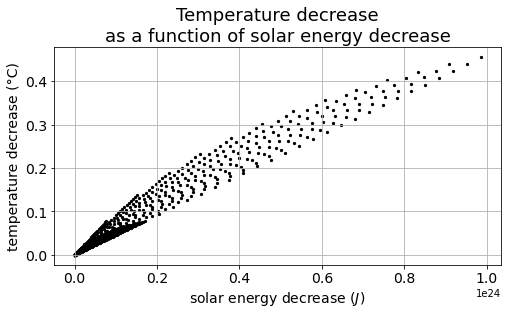

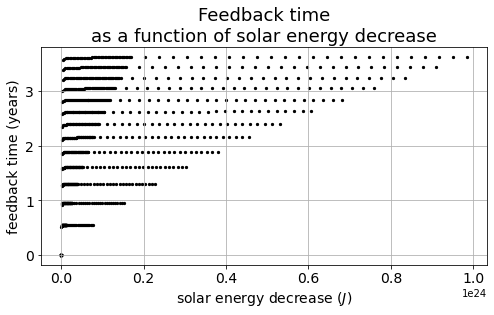

In [29]:
fig, ax1 = plt.subplots(figsize=(8,4))

co = range(len(nrj_sun_array.flatten()))
ax1.scatter(nrj_sun_array.flatten(),temp_ampli.flatten(),s=5,c="k")#,cmap="seismic")#,vmin=0,vmax=30)

sun_x = np.linspace(min(nrj_sun_array.flatten()),max(nrj_sun_array.flatten()),len(nrj_sun_array.flatten()))




ax1.tick_params(axis="both",labelsize=14)
ax1.set_xlabel("solar energy decrease ($J$)",fontsize=14)
ax1.set_ylabel("temperature decrease (°C)",fontsize=14)
ax1.set_title(f"Temperature decrease\nas a function of solar energy decrease",fontsize=18)

ax1.grid()
#ax1.legend(loc="center right",bbox_to_anchor=(1.5,0.1))
plt.show()

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.scatter(nrj_sun_array.flatten(),equi_time_dic_array.flatten(),s=5,c="k")#,cmap="seismic")#,vmin=0,vmax=30)

ax1.tick_params(axis="both",labelsize=14)
ax1.set_xlabel("solar energy decrease ($J$)",fontsize=14)
ax1.set_ylabel("feedback time (years)",fontsize=14)
ax1.set_title(f"Feedback time\nas a function of solar energy decrease",fontsize=18)

ax1.grid()
#ax1.legend(loc="center right",bbox_to_anchor=(1.5,0.1))
plt.show()

